Analysis Outline

Introduction of the dataset
- Acknowledgement of missing data.
- Definition of subsets of analysis (eg docs with at least 1 or at least 5 reviews)

Physician universe and demographics
- Coverage of healthgrades GI doctors (19,000+ national)
- Number of GI doctors in NY metro (947) = 6% of national active GI doctors (14,728 by ? year)
- Overall rating distribution

Influence of # of reviews
- Overall # of review distribution
- Number of reviews vs. rating (highlight top positive/negative)
- Doctors with large number of reviews: gender, age, location, rating

Influence of age
- Distribution of age
- Create age groups
- Number of reviews vs. age
- Rating by age group (are more experienced physicians better rated?)

Influence of gender
- Gender distribution: 22% female vs. 18% national
- Number of reviews is skewed by gender...
- ...but rating distribution is not

Influnece of educational history
- (todo) Educational history (where they came from)
- Rating distribution by top institutions
  (either #1 vs #2 or top few vs everyone else)

Influence of staff performance
- (todo) Rating vs. doctor score vs. staff score: heatmap
- Extreme: Doctors whose doc_score is very different from staff_score (check comments) 
 

In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
from scipy import stats
from matplotlib import pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

SMALL_SIZE = 10
MEDIUM_SIZE = 12
BIGGER_SIZE = 14
LARGE_SIZE = 16

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=LARGE_SIZE)  # fontsize of the figure title

pd.set_option('display.max_columns', 50)

In [3]:
r_fname = 'healthgrades_physicians_CARDIO_NY_full_raw.csv'
fname = 'healthgrades_physicians_CARDIO_NY_full.csv'
# Remove blank lines in raw csv file (scrapy bug for windows)
raw_data = pd.read_csv(r_fname)

# do not write index column
raw_data.to_csv(fname, index = False)  

# specify columns to read in for analysis
cols_in = ['name', 'hcp_id', 'age', 'gender', 'num_reviews', 'rating','doc_rating', 'staff_rating', \
            'practice_name', 'hosp_fellow', 'hosp_md', 'hosp_res', 
            'practice_addr','city', 'state', 'zipcode']

# read in fixed csv file
data = pd.read_csv(fname, usecols = cols_in)[cols_in] 
data.sample(5)

,name,hcp_id,age,gender,num_reviews,rating,doc_rating,staff_rating,practice_name,hosp_fellow,hosp_md,hosp_res,practice_addr,city,state,zipcode
1037,"Dr. Franklyn Laifer, MD",dr-franklyn-laifer-2v62v,79.0,Male,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"311 E 72nd St Apt 2G, New York, NY, 10021",New York,NY,10021
98,"Dr. Fadi Chaaban, MD",dr-fadi-chaaban-3hdht,53.0,Male,6,3.5,4.0|4.0|4.0|4.0,3.5|3.5|4.0,New Jersey Cardiology Asscos,St Michael's Med Ctr/Seton Hall University,Faculte Francaise De Medecine Et De Pharmacie,St Michael's Med Ctr/Seton Hall University,"5 Franklin Ave Ste 202, Belleville, NJ, 07109",Belleville,NJ,7109
1541,"Dr. Ahmed Aslam, MD",dr-ahmed-aslam-ys4q5,44.0,Male,0,NaN,NaN,NaN,Ahmad K Aslam/Ahmed F Aslam MDs,NaN,NaN,NaN,"945 Coney Island Ave, Brooklyn, NY, 11230",Brooklyn,NY,11230
1476,"Dr. Ankur Sethi, MD",dr-ankur-sethi-2sch6,37.0,Male,0,NaN,NaN,NaN,Mount Sinai Med Ctr Hsptlsts,NaN,NaN,NaN,"1 Gustave L Levy Pl, New York, NY, 10029",New York,NY,10029
930,"Dr. Noa Zemer Wassercug, MD",dr-noa-zemer-wassercug-xyn3hyx,NaN,Female,0,NaN,NaN,NaN,Drusin Mds,NaN,NaN,NaN,"161 Fort Washington Ave # 64, New York, NY, 10032",New York,NY,10032


In [4]:
# Data inspection
print(data.shape)
# check for duplicates based on hcp_id, there shouldn't be any
print(np.sum(data.duplicated(subset = ['hcp_id'])))
print(data.columns)
for field in data.columns:
    print(field, type(data.loc[0,field]))

(1572, 16)
0
Index(['name', 'hcp_id', 'age', 'gender', 'num_reviews', 'rating',
       'doc_rating', 'staff_rating', 'practice_name', 'hosp_fellow', 'hosp_md',
       'hosp_res', 'practice_addr', 'city', 'state', 'zipcode'],
      dtype='object')
name <class 'str'>
hcp_id <class 'str'>
age <class 'numpy.float64'>
gender <class 'str'>
num_reviews <class 'numpy.int64'>
rating <class 'numpy.float64'>
doc_rating <class 'str'>
staff_rating <class 'str'>
practice_name <class 'str'>
hosp_fellow <class 'str'>
hosp_md <class 'str'>
hosp_res <class 'str'>
practice_addr <class 'str'>
city <class 'str'>
state <class 'str'>
zipcode <class 'numpy.int64'>


In [5]:
# change zipcode to 5 digit string    
if data['zipcode'].dtype == 'int64':
    data['zipcode'] = data['zipcode'].apply(lambda x: '{0:05d}'.format(x))

# fix some empty values in gender
data.loc[ data['gender'].isin(['Male','Female']) == False, ['gender'] ] = np.nan

# convert detailed doc_rating and staff_rating from string to float
def split_score(data_series):
    y = []
    for x in data_series:
        if pd.isna(x) == False:
            y.append(np.mean([float(xi) for xi in x.split('|')]))
        else:
            y.append(x)
    return y

data['doc_score'] = split_score(data['doc_rating'])

# print(data['doc_rating'].head(5))
# print(data['doc_score'].head(5))

data['staff_score'] = split_score(data['staff_rating'])

# print(data['staff_rating'].head(5))
# print(data['staff_score'].head(5))
# print(data['staff_rating'].tail(5))
# print(data['staff_score'].tail(5))

# drop the two string columns and other columns not used
data = data.drop(columns=['doc_rating', 'staff_rating'])

# re-order
cols_1 = ['name', 'hcp_id', 'age', 'gender', 'num_reviews', 'rating','doc_score', 'staff_score', \
            'practice_name', 'hosp_fellow', 'hosp_md', 'hosp_res', 
            'practice_addr','city', 'state', 'zipcode']
data=data[cols_1]

data.sample(5)

,name,hcp_id,age,gender,num_reviews,rating,doc_score,staff_score,practice_name,hosp_fellow,hosp_md,hosp_res,practice_addr,city,state,zipcode
1416,"Dr. Icilma Fergus, MD",dr-icilma-fergus-2vv62,54.0,Female,2,3.0,3.0,2.833333,Harlem Hospital Center CAR,New York Presbyterian Hospital/Weill Cornell M...,SUNY,Albert Einstein College Med,"506 Malcolm X Blvd Ste MLK15101, New York, NY,...",New York,NY,10037
602,"Shahed Quraishi, MB",dr-shahed-quraishi-37pdj,50.0,Male,0,NaN,NaN,NaN,WYCKOFF HEIGHTS MEDICAL CENTER,NaN,"Bangalore Medical College, Rajiv Gandhi Univer...",NaN,"374 Stockholm St, Brooklyn, NY, 11237",Brooklyn,NY,11237
883,"Dr. Olena Dotsenko, MD",dr-olena-dotsenko-xktfl,45.0,Female,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"361 91st St Apt 2, Brooklyn, NY, 11209",Brooklyn,NY,11209
206,"Dr. Joshua Socolow, MD",dr-joshua-socolow-3crqx,47.0,NaN,1,5.0,5.0,5.000000,NYP Brooklyn Methodist Hospital,Emory University School Of Medicine,Washington University In St Louis School Of Me...,University Of Chicago Medical Center,"506 6th St, Brooklyn, NY, 11215",Brooklyn,NY,11215
1321,"Dr. Mohammad Sandhu, MD",dr-mohammed-sandhu-y5bld,73.0,Male,4,4.0,5.0,4.166667,Newark Beth Israel Med Ctr Card,NaN,NaN,Jersey City Med Center,"672 Broadway, Bayonne, NJ, 07002",Bayonne,NJ,07002


In [6]:
# count % of missing values by column
mv_cols = pd.DataFrame(data = np.sum(data.isnull(), axis = 0) / data.shape[0], columns = ['pct_mv'] )
print(mv_cols.to_string(formatters = {'pct_mv': '{:.0%}'.format}))

              pct_mv
name              0%
hcp_id            0%
age              19%
gender            9%
num_reviews       0%
rating           37%
doc_score        37%
staff_score      38%
practice_name    13%
hosp_fellow      40%
hosp_md          23%
hosp_res         32%
practice_addr     0%
city              0%
state             0%
zipcode           0%


In [7]:
# create indicator for whether the doctor has been reviewed or not
data['has_review'] = True
data.loc[ data['num_reviews'] == 0, 'has_review'] = False
print(data['has_review'].value_counts())

True     998
False    574
Name: has_review, dtype: int64


In [8]:
# summary stats of key numeric variables
# data.loc[:,['age','num_reviews','rating','doc_score','staff_score']].describe()
data['num_reviews'].describe()

count    1572.000000
mean        4.839059
std        13.090885
min         0.000000
25%         0.000000
50%         2.000000
75%         6.000000
max       421.000000
Name: num_reviews, dtype: float64

Text(0.5,1,'Distribution of Overall Rating')

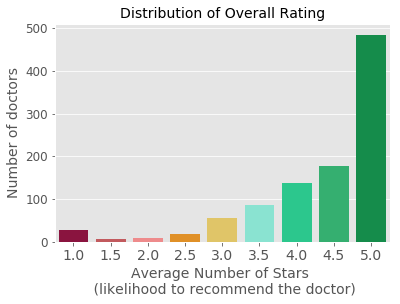

In [9]:
# use
# overall distribution of score among doctors with at least 1 review
colors = ["cranberry","faded red", "salmon pink", "tangerine", "maize", "tiffany blue", \
          "aqua green","algae green","emerald"]

ax = sns.countplot( x = 'rating', data = data, palette = sns.xkcd_palette(colors) )
plt.xticks(fontsize = 14)
plt.xlabel('Average Number of Stars \n (likelihood to recommend the doctor)', fontsize = 14)
plt.ylabel('Number of doctors', fontsize = 14)
plt.title('Distribution of Overall Rating', fontsize = 14)

Text(0.5,1,'Histogram of Number of Reviews \n for Gastroenterologists in New York Metro Area')

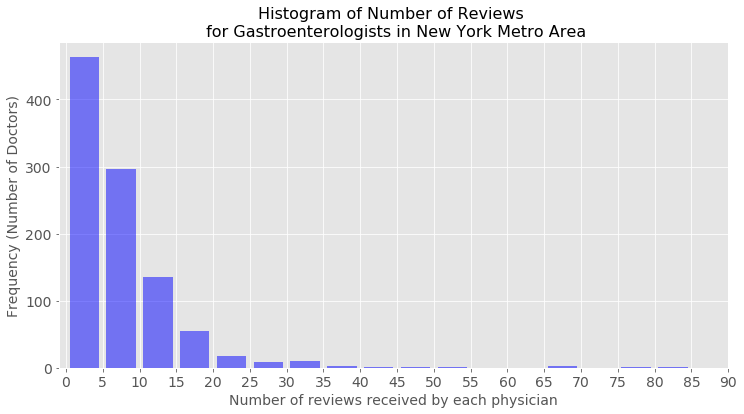

In [10]:
# use
# overall distribution of the number of reviews among doctors with at least one review (998)
# subdata: physicians with >= 1 reviews
subdata = data[ data['has_review'] == True ]
bstep = 5
bmax = int(round(subdata.num_reviews.max()/bstep)*bstep)
plt.figure(figsize=(12,6))
hout = plt.hist(subdata.num_reviews.dropna(), bins = range(0,bmax,bstep), color = "blue", alpha = 0.5, rwidth = 0.8)
plt.xticks(np.arange(-bstep*2,bmax+2*bstep,bstep), fontsize = 14)
plt.yticks(fontsize = 14)    
plt.xlim([-1,90])
plt.xlabel('Number of reviews received by each physician', fontsize = 14)
plt.ylabel('Frequency (Number of Doctors)',fontsize = 14)
plt.title('Histogram of Number of Reviews \n for Cardiologists in New York Metro Area', fontsize = 16)

In [11]:
#plt.figure()
#plt.plot(x = hout[1][1:], y = np.cumsum(hout[0])/np.sum(hout[0]) ) 
print(list(zip(hout[1][1:],np.cumsum(hout[0])/np.sum(hout[0]))))
# 20% doctors have >= 15 reviews 
# 39% doctors have >= 10 reviews
# 64% doctors have >= 5 reviews

[(5, 0.46439317953861586), (10, 0.7612838515546639), (15, 0.8966900702106319), (20, 0.9518555667001003), (25, 0.9699097291875627), (30, 0.9779338014042126), (35, 0.9879638916750251), (40, 0.9909729187562688), (45, 0.9919759277833501), (50, 0.9929789368104313), (55, 0.9939819458375125), (60, 0.9939819458375125), (65, 0.9939819458375125), (70, 0.995987963891675), (75, 0.995987963891675), (80, 0.9969909729187563), (85, 0.9979939819458375), (90, 0.9979939819458375), (95, 0.9979939819458375), (100, 0.9989969909729187), (105, 0.9989969909729187), (110, 1.0), (115, 1.0), (120, 1.0), (125, 1.0), (130, 1.0), (135, 1.0), (140, 1.0), (145, 1.0), (150, 1.0), (155, 1.0), (160, 1.0), (165, 1.0), (170, 1.0), (175, 1.0), (180, 1.0), (185, 1.0), (190, 1.0), (195, 1.0), (200, 1.0), (205, 1.0), (210, 1.0), (215, 1.0), (220, 1.0), (225, 1.0), (230, 1.0), (235, 1.0), (240, 1.0), (245, 1.0), (250, 1.0), (255, 1.0), (260, 1.0), (265, 1.0), (270, 1.0), (275, 1.0), (280, 1.0), (285, 1.0), (290, 1.0), (295, 1.0

Although the healthgrades physician database appears to be quite comprehensive, the patient reviews are collected via a survey on the physician's page on healthgrades.com. Around 22% of physicians have not been reviewed. In the histogram above, we only consider physicians with at least 1 review (total 681 gastroenterologists). 

It's clear that the number of reviews per physician follows an exponential distribution, with 36% receiving less than 5 reviews, 25% receiving 5 to 9 reviews, and 39% receiving 10 reviews or more. Only 4.3% of doctors receive 30 reviews or more, and < 2% of doctors receive 50 reviews or more. Next we take a look at the relationship between the number of reviews and overall star rating. 

In [12]:
# Create categorical variable (L/M/H) based on num_reviews
# cut_bins = pd.IntervalIndex.from_tuples([(0, 5), (5, 10), (10, 200)])
# n_rev_c = pd.DataFrame(pd.cut(subdata['num_reviews'], bins = [0,5,10,200], right = False,  \
#                              labels = ['L', 'M', 'H'] ))

subdata['n_rev_c'] = pd.cut(subdata['num_reviews'], bins = [0,5,10,200], right = False,  \
                             labels = ['L', 'M', 'H'] )
# subdata.loc[:,['num_reviews','n_rev_c']].head(10)
# subdata['n_rev_c'].dtype

C:\Users\yanqi\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


(0, 50)

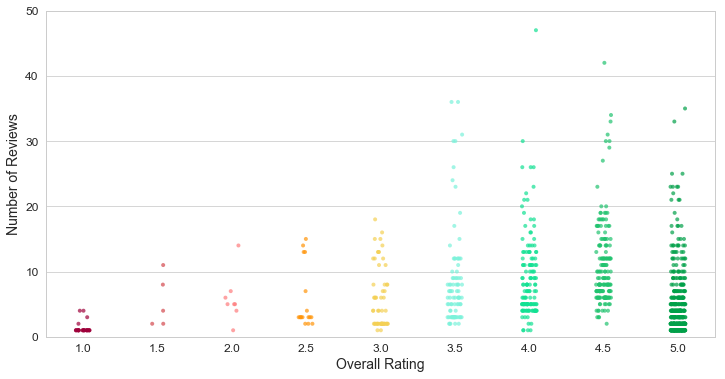

In [14]:
# use
# Number of reviews vs. overall rating
plt.figure(figsize = (12,6))
sns.set_style("whitegrid")
colors = ["cranberry","faded red", "salmon pink", "tangerine", "maize", "tiffany blue", \
          "aqua green","algae green","emerald"]
sns.stripplot(x="rating", y="num_reviews", data=subdata, size = 4, alpha = 0.7, jitter = True, \
              palette = sns.xkcd_palette(colors));
plt.xlabel('Overall Rating')
plt.ylabel('Number of Reviews')
plt.ylim(0,50)

Text(0,0.5,'Number of doctors')

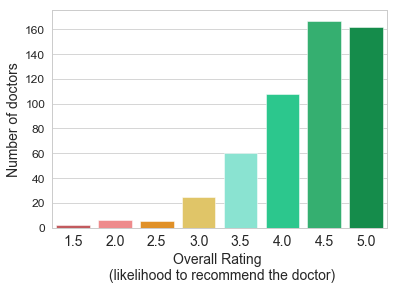

In [15]:
# use
# overall distribution of score among doctors with at least 5 reviews 
subdata5 = data.loc[ data['num_reviews'] >= 5 ]

colors = [ "faded red", "salmon pink", "tangerine", "maize", "tiffany blue", \
          "aqua green","algae green","emerald"]

ax = sns.countplot( x = 'rating', data = subdata5, palette = sns.xkcd_palette(colors) )
plt.xticks(fontsize = 14)
plt.xlabel('Overall Rating \n (likelihood to recommend the doctor)', fontsize = 14)
plt.ylabel('Number of doctors', fontsize = 14)

In [16]:
subdata5['rating'].value_counts() #/subdata5['rating'].count()

4.5    167
5.0    162
4.0    108
3.5     60
3.0     25
2.0      6
2.5      5
1.5      2
Name: rating, dtype: int64

In [17]:
# order is more correct than value_counts function
# stats.itemfreq(subdata5['rating'])
np.unique(subdata5['rating'], return_counts=True) 

(array([1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ]),
 array([  2,   6,   5,  25,  60, 108, 167, 162], dtype=int64))

In [18]:
subdata5['rating'].describe()

count    535.000000
mean       4.310280
std        0.670392
min        1.500000
25%        4.000000
50%        4.500000
75%        5.000000
max        5.000000
Name: rating, dtype: float64

The scatterplot of star rating vs. number of reviews shows doctors with the poorest ratings are less likely to get a large number reviews. Contrary to intuition, few patients who are willing to submit a review are motivated by a very negative experience with the doctor. Patients seem to be generally happy with the gastroenterologists in NY metro area. 

Indeed, when we focus on only the physicians with at least 5 reviews (subdata5, total 433 doctors), the distribution of the overall rating changes quite a bit. Notably the drop in the number of doctors getting 5 star ratings. This should be a more robust distribution with a minimally acceptable sample size on which each average star rating is based. The average rating is close to 4 and more than 70 doctors receive perfect 5 stars. 

These charts helps guide consumers in their interpretation of the ratings on healthgrades.com. One would perhaps be best to avoid the GI doctors with < 3 star rating based on 5 or more reviews. Similarly, to find top positively rated doctors, 5 star rating based on 5 or more reviews, 4.5 stars based on more than 10 reviews, or even more stringent criteria may be used. 

In [19]:
# who are the doctors with extremely large # of reviews
n_high = 50
subdata.loc[ subdata['num_reviews'] >= n_high, ['name','age','gender','num_reviews', \
                                            'rating','practice_name','practice_addr','hosp_fellow', 'hosp_md'] ]

,name,age,gender,num_reviews,rating,practice_name,practice_addr,hosp_fellow,hosp_md
63,"Dr. Arthur Kennish, MD",68.0,Male,67,4.5,Arthur Kennish MD,"108 E 96th St, New York, NY, 10128",Mt Sinai Hospital,Albert Einstein College Of Medicine Of Yeshiva...
497,"Dr. Adam Goldman, MD",52.0,Male,67,5.0,Metropolitan Vein and Aesthetic Center,"3773 103rd St, Corona, NY, 11368",Cardiovascular Diseases - Albert Einstein/Jac...,Albert Einstein College of Medicine in New Yor...
572,"Dr. Arthur Weisenseel Jr, MD",81.0,Male,78,5.0,Weisenseel & Unger MDs,"12 E 86th St Ofc 4, New York, NY, 10028",Mt Sinai Med Center,GEORGETOWN UNIV SCH OF MED
589,"Dr. Rick Pumill, MD",59.0,Male,82,5.0,Cross County Cardiology,"38 Meadowlands Pkwy, Secaucus, NJ, 07094",Seton Hall University,Ross University
592,"Dr. Irfan Admani, MD",46.0,Male,107,5.0,Cross County Cardiology,"38 Meadowlands Pkwy, Secaucus, NJ, 07094",Saint Michael's Medical Center,St. George's University
1225,"Dr. Haroon Faraz, MD",41.0,Male,99,5.0,CarePoint Medical Group,"330 Grand St # 100, Hoboken, NJ, 07030",Wayne State University School of Medicine,Dow Medical College Karachi University
1230,"Dr. Jeffrey Fisher, MD",68.0,Male,421,5.0,"Cardiology Consultants Of New York, P.C.","311 E 72nd St Apt 1C, New York, NY, 10021",Johns Hopkins Hospital,Albert Einstein College Of Medicine Of Yeshiva...
1486,"Dr. Luiza Petre, MD",NaN,Female,51,5.0,Medi Weightloss,"115 E 57th St Ste 1450, New York, NY, 10022",Beth Israel Med Ctr-Mt Sinai Sch Med,Universitatea De Medicina Si Farmacie Carol Da...


What other factors influence the doctor's star rating? One would reasonably expect more experienced doctors who has been practicing for longer will be reviewed more favorably. Using age as a proxy for years of experience, we look at how this factor relates to the star rating. 

1277

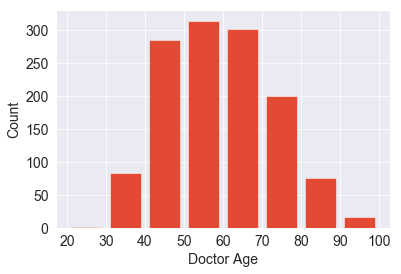

In [20]:
# use
# age distribution: 22% missing
sns.set_style('darkgrid')
plt.hist(data.age.dropna(), rwidth = 0.8, bins = range(20,110,10))
plt.xticks(range(20,110,10), fontsize = 14)
plt.yticks(fontsize = 14)
plt.xlabel('Doctor Age')
plt.ylabel('Count')
# Majority of the gastroenterologists in NY metro area are between 50 and 70 years old
len(data.age.dropna())

In [22]:
# create age groups
edge_low = int(np.floor(min(data['age'].dropna())/10)*10)
edge_high = int(np.ceil(max(data['age'].dropna())/10)*10)
data['age_grp'] = pd.cut(data['age'], bins = np.arange(edge_low,edge_high+10,10), right = False)
data.loc[:,['age','age_grp']].sample(5)

,age,age_grp
439,59.0,"[50, 60)"
956,34.0,"[30, 40)"
764,65.0,"[60, 70)"
305,53.0,"[50, 60)"
1086,36.0,"[30, 40)"


In [23]:
data['age_grp'].value_counts() #/data['age_grp'].value_counts().sum()

[50, 60)     314
[60, 70)     302
[40, 50)     285
[70, 80)     200
[30, 40)      83
[80, 90)      75
[90, 100)     16
[20, 30)       1
[10, 20)       1
Name: age_grp, dtype: int64

Text(0,0.5,'Number of Reviews')

<Figure size 720x432 with 0 Axes>

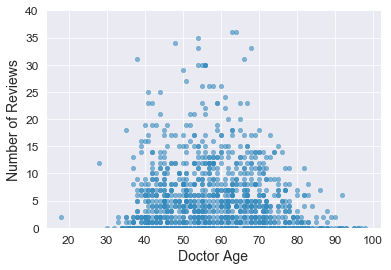

In [24]:
# use
plt.figure(figsize =(10,6))
data.plot(kind='scatter',x='age', y='num_reviews', alpha = 0.6)
plt.ylim(0,40)
plt.xlabel('Doctor Age', fontsize = 14)
plt.ylabel('Number of Reviews', fontsize = 14)
# doctors between 50 and 70 years old tend to get a larger number of reviews on average, and the younger and older age 
# groups generally receive fewer reviews. This could be due to the 50-70 year old physicians having a longer practicing 
# history and cumulative patient count than the younger group, and also being more actively practicing than the older group.
# This could also be due to a selection bias from patients for GI doctors in the 50-70 age group.

In [25]:
subdata5 = data.loc[ data['num_reviews'] >= 5 ]
subdata5.head(2)

,name,hcp_id,age,gender,num_reviews,rating,doc_score,staff_score,practice_name,hosp_fellow,hosp_md,hosp_res,practice_addr,city,state,zipcode,has_review,age_grp
1,"Dr. Sunil Patel, MD",dr-sunil-patel-3djp9,46.0,Male,15,3.0,3.000,3.5,Prime Heart,Umdnj-University Hospital,U Of Bristol,Umdnj-University Hospital,"377 Jersey Ave Ste 230, Jersey City, NJ, 07302",Jersey City,NJ,07302,True,"[40, 50)"
2,"Dr. William Silver, MD",dr-william-silver-xln9f,77.0,Male,5,4.5,4.875,4.0,William A Silver MD,Beth Israel Medical Center,"Hadassah Medical School, The Hebrew University...",Beth Israel Med Center,"60 Gramercy Park North, Brooklyn, NY, 11249",Brooklyn,NY,11249,True,"[70, 80)"


Text(0,0.5,'Overall Rating')

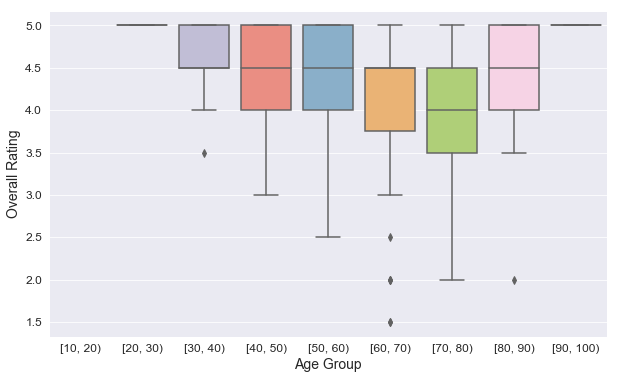

In [26]:
# use
plt.figure(figsize =(10,6))

# 
subdata5 = data.loc[ data['num_reviews'] >= 5 ]
sns.boxplot(x="age_grp", y="rating", data=subdata5, palette="Set3")
plt.xlabel('Age Group')
plt.ylabel('Overall Rating')

In [27]:
subdata5['age_grp'].value_counts()

[50, 60)     160
[60, 70)     139
[40, 50)     119
[70, 80)      56
[30, 40)      17
[80, 90)       9
[90, 100)      1
[20, 30)       1
[10, 20)       0
Name: age_grp, dtype: int64

In [30]:
# test if the age group [60, 70) has different average rating from the [40,50) and [50,60) groups
age_grps = np.sort(subdata5['age_grp'].unique().dropna())

age_grp_rating = {}
for grp in age_grps:
    age_grp_rating[str(grp)] = subdata5.loc[ subdata5['age_grp'] == grp, ['rating'] ]  

print(stats.f_oneway( age_grp_rating['[40, 50)'] ,age_grp_rating['[50, 60)'], age_grp_rating['[60, 70)']))
print(stats.f_oneway( age_grp_rating['[40, 50)'] ,age_grp_rating['[50, 60)'], age_grp_rating['[70, 80)']))

# [60,70)'s satisfaction is lower than the [40,50) and [50,60) groups
# [70,80)'s satisfaction is also lower than the [40,50) and [50,60) groups

F_onewayResult(statistic=array([8.18230442]), pvalue=array([0.00032715]))
F_onewayResult(statistic=array([6.81963944]), pvalue=array([0.00125167]))


In [31]:
subdata5.shape[0]

535

How does the gender of the doctor impact the rating? Is there any difference between female and male doctors?

In [32]:
# use
# gender distribution (884 doctors with gender info, 7% missing)
# total 688 male and 196 female doctors: 78% of NY metro GI docs in the HG database are male 
# to look up: % F / M GI docs in the US = 17.6% (out of 14,728 total)
print(data.gender.value_counts())

# counts of each variable split by gender
# 75% of male doctors have been reviewed, while only 57% of female doctors have been reviewed
data.groupby('gender').count()
plt.figure(figsize =(3,3))

Male      1108
Female     323
Name: gender, dtype: int64


<Figure size 216x216 with 0 Axes>

<Figure size 216x216 with 0 Axes>

2.7708978328173375
5.324007220216607


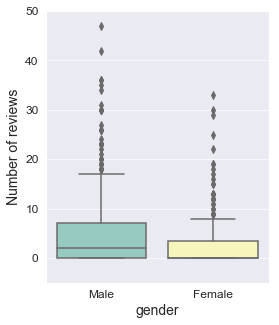

In [33]:
# use
# distribution of reviews by gender
# sns.boxplot(x='gender', y='num_reviews', data=subdata.loc[ subdata['num_reviews'] <= 50 ])
plt.figure(figsize = (4,5))
sns.boxplot( x ='gender', y ='num_reviews', data=data, palette = 'Set3')
plt.ylim(-5, 50)
plt.ylabel('Number of reviews')
stats.ttest_ind(data.loc[ data['gender'] == 'Female', 'num_reviews'], \
                data.loc[ data['gender'] == 'Male', 'num_reviews'])
# Female GI doctors receive seem to have lower visibility among patients and receive fewer reviews
# The doctors who receive extremely large number of reviews are almost all male doctors
print(data.loc[ data['gender'] == 'Female', 'num_reviews'].mean())
print(data.loc[ data['gender'] == 'Male', 'num_reviews'].mean())

69

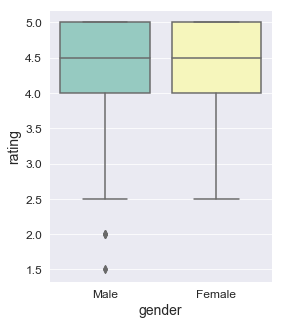

In [34]:
# use
# distribution of overall rating by gender
plt.figure(figsize = (4,5))
sns.boxplot( x ='gender', y ='rating', data=subdata5, palette = 'Set3')
np.sum(subdata5.loc[:,['gender','rating']].isnull().any(axis = 1))
# no difference in rating distribution for female & male doctors with 5 or more reviews


In [30]:
# plt.figure(figsize = (12,4))
# plt.subplot(121)
# sns.boxplot( y ='gender', x ='num_reviews', data=data, palette = 'Set3')
# plt.xlim(-5, 50)
# plt.xlabel('Number of reviews')
# plt.subplot(122)
# sns.boxplot( y ='gender', x ='rating', data=subdata5, palette = 'Set3')
# plt.xlabel('Rating')

In [35]:
numdata = subdata.loc[:,['age', 'num_reviews', 'doc_score', 'staff_score', 'rating']]
numdata.corr(min_periods = 50)

,age,num_reviews,doc_score,staff_score,rating
age,1.000000,0.001058,-0.149188,-0.203627,-0.152966
num_reviews,0.001058,1.000000,0.024865,0.043165,0.024253
doc_score,-0.149188,0.024865,1.000000,0.845401,0.958422
staff_score,-0.203627,0.043165,0.845401,1.000000,0.842811
rating,-0.152966,0.024253,0.958422,0.842811,1.000000


In [32]:
# use
scores = subdata5.loc[:,['doc_score','staff_score', 'rating']]
scores.corr(min_periods = 50)

,doc_score,staff_score,rating
doc_score,1.000000,0.841663,0.957498
staff_score,0.841663,1.000000,0.860684
rating,0.957498,0.860684,1.000000


In [36]:
from pandas.plotting import scatter_matrix
scatter_matrix(scores.loc[:,['rating','staff_score','doc_score']], \
               alpha=0.2, figsize=(12, 12), diagonal='hist')

NameError: name 'scores' is not defined

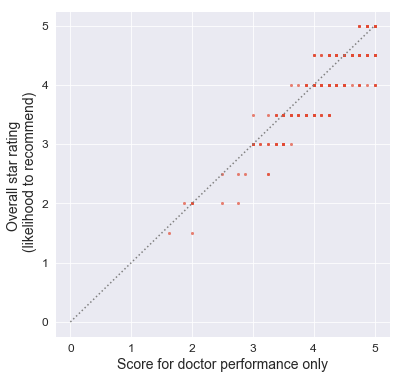

In [37]:
plt.figure(figsize = (6,6))
plt.scatter(x="doc_score", y="rating", data=subdata5, alpha = 0.7, s = 6);
plt.xlabel('Score for doctor performance only')
plt.ylabel('Overall star rating \n (likelihood to recommend)')
plt.plot(np.arange(0,5.5,0.5), np.arange(0,5.5,0.5), color = 'gray', linestyle=':')
plt.show()

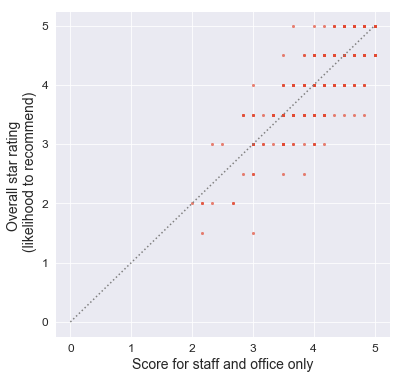

In [38]:
plt.figure(figsize = (6,6))
plt.scatter(x="staff_score", y="rating", data=subdata5, alpha = 0.7, s = 6);
plt.xlabel('Score for staff and office only')
plt.ylabel('Overall star rating \n (likelihood to recommend)')
plt.plot(np.arange(0,5.5,0.5), np.arange(0,5.5,0.5), color = 'gray', linestyle=':')
plt.show()

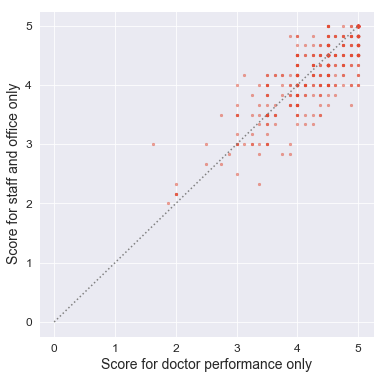

In [39]:
plt.figure(figsize = (6,6))
plt.scatter(x="doc_score", y="staff_score", data=subdata5, s = 7, alpha = 0.5);
plt.plot(np.arange(0,5.5,0.5), np.arange(0,5.5,0.5), color = 'gray', linestyle=':')
plt.xlabel('Score for doctor performance only')
plt.ylabel('Score for staff and office only')
plt.rc('xtick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=BIGGER_SIZE)
plt.show()

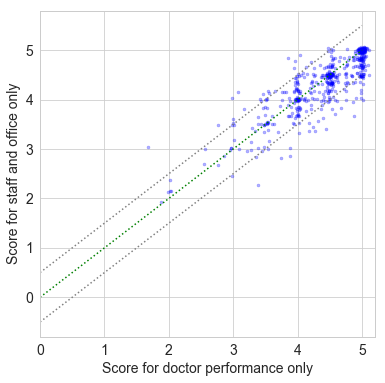

In [40]:
# use
def rand_jitter(arr):
    stdev = .01*(max(arr)-min(arr))
    return arr + np.random.randn(len(arr)) * stdev

def jitter(x, y, s=20, c='b', marker='o', cmap=None, norm=None, vmin=None, vmax=None, alpha=None, linewidths=None, verts=None, hold=None, **kwargs):
    return plt.scatter(rand_jitter(x), rand_jitter(y), s=s, c=c, marker=marker, cmap=cmap, norm=norm, vmin=vmin, vmax=vmax, alpha=alpha, linewidths=linewidths, verts=verts, hold=hold, **kwargs)

plt.rc('xtick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=BIGGER_SIZE)

sns.set_style('whitegrid')
plt.figure(figsize = (6,6))
jitter( subdata5['doc_score'], subdata5['staff_score'], s = 9, alpha = 0.3);
plt.plot(np.arange(0,5.5,0.5), np.arange(0,5.5,0.5), color = 'green', linestyle=':')
plt.plot(np.arange(0,5.5,0.5), np.arange(0,5.5,0.5) + 0.5, color = 'gray', linestyle=':')
plt.plot(np.arange(0,5.5,0.5), np.arange(0,5.5,0.5) - 0.5, color = 'gray', linestyle=':')
plt.xlabel('Score for doctor performance only')
plt.ylabel('Score for staff and office only')
plt.xlim(0,5.2)
plt.show()

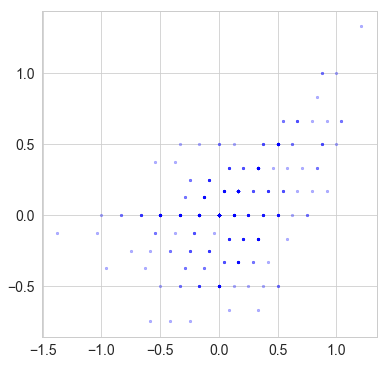

In [41]:
plt.figure(figsize = (6,6))
xval = subdata5['doc_score'] - subdata5['staff_score']
yval = subdata5['rating'] - subdata5.loc[:,['doc_score','staff_score']].min(axis = 1)
plt.scatter(xval, yval, s= 7, alpha = 0.3, color = 'b')

(-1.5, 1.5)

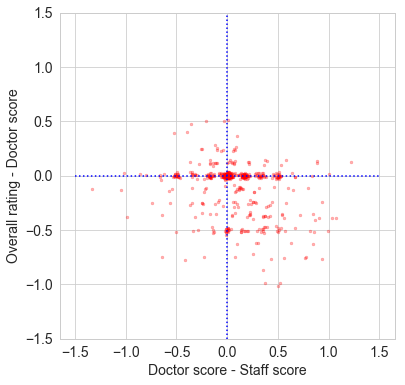

In [42]:
# use
sns.set_style('whitegrid')
plt.figure(figsize = (6,6))
xval = subdata5['doc_score'] - subdata5['staff_score']
yval = subdata5['rating'] - subdata5['doc_score']
jitter(xval, yval, s = 8, alpha = 0.3, c = 'r')
plt.plot(np.arange(-1.5,2,0.5), np.zeros(len(np.arange(-1.5,2,0.5))), color = 'b', linestyle=':')
plt.plot(np.zeros(len(np.arange(-1.5,2,0.5))), np.arange(-1.5,2,0.5), color = 'b', linestyle=':')
plt.xlabel('Doctor score - Staff score')
plt.ylabel('Overall rating - Doctor score')
plt.ylim(-1.5,1.5)
# plt.savefig('score difference scatter', format = 'png')

count    535.000000
mean       0.073520
std        0.324228
min       -1.375000
25%        0.000000
50%        0.000000
75%        0.208333
max        1.208333
dtype: float64


Ttest_1sampResult(statistic=-708.1448825831469, pvalue=0.0)

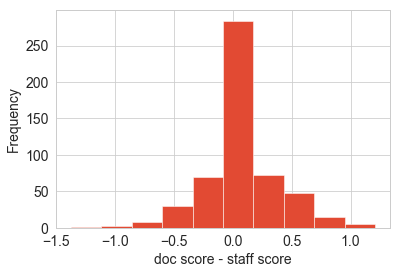

In [43]:
print(xval.describe())
xval.plot(kind='hist')
plt.xlabel('doc score - staff score')
stats.ttest_1samp(xval, 10)
# doctor score is more likely to be higher than staff score. 

count    535.000000
mean      -0.099065
std        0.229494
min       -1.000000
25%       -0.125000
50%        0.000000
75%        0.000000
max        0.500000
dtype: float64


Ttest_1sampResult(statistic=-1017.8553117074647, pvalue=0.0)

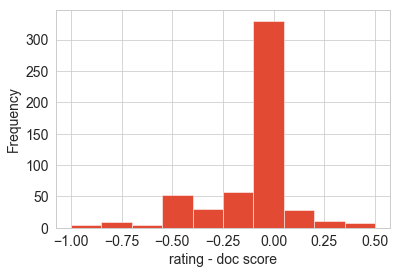

In [44]:
print(yval.describe())
yval.plot(kind='hist')
plt.xlabel('rating - doc score')
stats.ttest_1samp(yval, 10)

In [52]:
subdata5.head(2)

,name,hcp_id,age,gender,num_reviews,rating,doc_score,staff_score,practice_name,hosp_fellow,hosp_md,hosp_res,practice_addr,city,state,zipcode,has_review,age_grp
0,"Dr. Blair Lewis, MD",dr-blair-lewis-2gfpg,62.0,Male,26,5.0,4.875,4.666667,Blair S Lewis MD PC,Mt Sinai Med Center,Albert Einstein College Of Medicine Of Yeshiva...,Montefiore Med Center,"1067 5th Ave, New York, NY, 10128",New York,NY,10128,True,"[60, 70)"
14,"Dr. Zamir Brelvi, MD",dr-zamir-brelvi-xy8pj,59.0,Male,15,4.0,4.125,3.833333,NaN,NaN,Umdnj--New Jersey Medical School,Umdnj-University Hospital,"90 Bergen St, Newark, NJ, 07103",Newark,NJ,07103,True,"[50, 60)"


In [48]:
# Institutions for the exceptional doctors 
topdata = subdata5.loc[ (subdata5['rating'] == 5) & (subdata5['num_reviews'] >= 10),:]
#topdata.to_csv('top 5 star docs with at least 10 reviews.csv')
# 2 practices with > 1 doctor in the exceptional list
topdoc_practice_n = topdata['practice_name'].value_counts().to_frame('topdoc_practice_n')
topdoc_practice_p = (topdata['practice_name'].value_counts()/np.sum(topdata['practice_name'].value_counts())).to_frame('topdoc_practice_p')
topdoc_practice = pd.concat([topdoc_practice_n, topdoc_practice_p], axis = 1) 
print(topdoc_practice.iloc[0:5,:])

top_practice_n = subdata5['practice_name'].value_counts().to_frame('top_practice_n')
top_practice_p = (subdata5['practice_name'].value_counts()/np.sum(subdata5['practice_name'].value_counts())).to_frame('top_practice_p')
top_practice = pd.concat([top_practice_n, top_practice_p], axis = 1) 
top_practice.iloc[0:10,:]

                                                    topdoc_practice_n  \
Columbia University Medical Center Division of ...                  3   
Cross County Cardiology                                             3   
Mount Sinai Heart                                                   2   
HeartHealth, a Program of the Dalio Institute o...                  2   
Lenox Hill Heart and Vascular Institute, New Yo...                  2   

                                                    topdoc_practice_p  
Columbia University Medical Center Division of ...           0.048387  
Cross County Cardiology                                      0.048387  
Mount Sinai Heart                                            0.032258  
HeartHealth, a Program of the Dalio Institute o...           0.032258  
Lenox Hill Heart and Vascular Institute, New Yo...           0.032258  


,top_practice_n,top_practice_p
Columbia University Medical Center Division of Cardiology,13,0.026860
Mount Sinai Heart,8,0.016529
Cardiology at Weill Cornell Medical Center,8,0.016529
Columbia Doctors Midtown,8,0.016529
University Cardiology Assocs,7,0.014463
Weill Cornell Cardiology,7,0.014463
New York Cardiology Associates,7,0.014463
"Lenox Hill Heart and Vascular Institute, New York, NY",6,0.012397
Staten Island Heart PC,5,0.010331
Total Cardiology Care,5,0.010331
